# Reading in Peak data using TreeMakers

Erik Hogenbirk, September 2016, ehogenbi@nikhef.nl



## Introduction

Aren't TreeMakers great? They give you nice features like reloading of data from file, version control, and give you a clean variable in RAM that you can play with right away.

But wait, doesn't a TreeMaker give you *event-by-event* information? Yes, it does, and sometimes that's not what you want. In particular, if you want to see all peaks in a dataset. Think of things like a single-electron S2 analysis, a peak classification study, etc.

There is a class in hax called PeakExtractor that inherits from TreeMaker and does essentially the same as TreeMaker, but peak-by-peak. Event properties are also added if you include those TreeMakers. For peaks in the same event, you'll have the same event information.

One thing that's pretty important for peak data extraction is *cuts*. This is mainly because of lone hits: most peaks in events are lone hits (dark counts, noise, etc). This is typically a few hundred per event. So, unless you're super interested in that junk or you have infinite patience and RAM, you will want to throw those out even before reading them in.

This example will walk you through how to read in all the peak data you need, and some special cases that arise. The focus of this example will be on the data reading, the analysis is up to you! ;)

## Boilerplate

As usual, we have some initialization to do...

In [1]:
%run 'boiler_plate.py'
%matplotlib inline

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Hax initialization

Start hax and point it to the data. For special options, check out the other examples.

In [2]:
hax.init(pax_version_policy = 'loose', main_data_paths = ['/home/erik/win/data/xe1t/processed'])

In [3]:
# Just a random Cs dataset, rather small so perfect for demonstration purposes
dataset = '160905_1329'

## Make a class and read in data

Now the magic happens: we make our own PeakExtractor class. Settings are passed by setting the objects to proper values. Let's look at the following example:

In [4]:
from hax.treemakers.peak_treemakers import PeakExtractor
class CoinPeaksInTPC(PeakExtractor):
    __version__ = '0.0.1'
    stop_after = 10
    peak_cut_list = ['detector == "tpc"', 'type !="lone_hit"']
    peak_fields = ['area', 'range_50p_area', 'type']
    

Running this TreeMaker will read in all peak fields specified in peak_fields for peaks that aren't lone hits, and happen in the TPC. There is a limit to stop_after 10 events, since this is just a short demonstration.

In [5]:
d_tpit = hax.minitrees.load(dataset, [CoinPeaksInTPC, 'Fundamentals'])
d_tpit.head()

,event_number,area,range_50p_area,type,event_duration,event_time,run_number
0,0,2.658966,33.944365,3,3071160,1473082165000580180,2644
1,0,6.276015,141.668850,3,3071160,1473082165000580180,2644
2,0,5.720890,139.449782,3,3071160,1473082165000580180,2644
3,0,864.883179,58.160931,1,3071160,1473082165000580180,2644
4,0,3279.531738,327.261619,2,3071160,1473082165000580180,2644


## A closer look at peak types

Usually, you'll want at least the selection of no lone hits and peaks in the TPC. Here's why:

In [6]:
class AllPeaks(PeakExtractor):
    __version__ = '0.0.1'
    stop_after = 1000
    peak_cut_list = [] # No cuts, this is also default
    peak_fields = ['area', 'range_50p_area', 'type', 'detector']

In [7]:
d_all = hax.minitrees.load(dataset, [AllPeaks, 'Fundamentals'], force_reload=True)

In [8]:
print("Total peaks: %d in %d events" % (len(d_all), len(np.unique(d_all['event_number']))))

Total peaks: 382154 in 1000 events


Wow, we have an average of ~400 peaks per event. What are they?

In [9]:
def fancy_bar(x, y, xlabel, ylabel, title):
    """
    x: list of bin labels
    y: list of amplitude (i.e. frequency)
    """
    s = pd.Series(
    y,
    index = x
    )
    
    #Set descriptions:
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    
    #Plot the data:
    my_colors = 'rgbkymc'  #red, green, blue, black, etc.
    s.plot(
        kind='bar', 
        color=my_colors,
    )
    return None

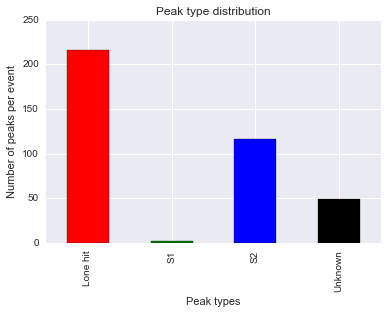

In [10]:
# Make a histogram manually
height_types = [0.001*len(d_all[d_all['type']==i]) for i in range(4)]
height_detector = [0.001*len(d_all[d_all['detector']==i]) for i in range(6)]

fancy_bar(['Lone hit', 'S1', 'S2', 'Unknown'], height_types, xlabel='Peak types', ylabel='Number of peaks per event', 
          title='Peak type distribution')
plt.show()

As you can see, the lone hits are by far the most frequent, then followed by (mostly single-electron) S2s. In this Cs dataset, there's over 100 of these per event. You can of course also consider cutting those out.

For peak classification or any peak selection, the following plot is usually of interest:

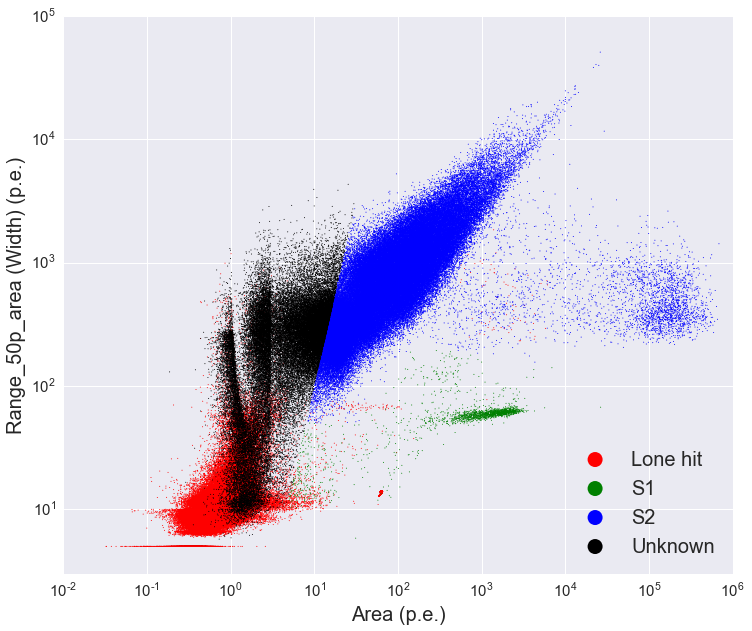

In [11]:
plt.figure(figsize=(12, 10))

my_colors = 'rgbkymc'
labels = ['Lone hit', 'S1', 'S2', 'Unknown']
for pt, c, l in zip(range(4), my_colors, labels):
    sel = d_all['type'] == pt
    plt.scatter(d_all[sel]['area'], d_all[sel]['range_50p_area'], c=c, edgecolors='None', marker='.', s=4, label=l)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01, 10**6)
plt.ylim(3, 10**5)
plt.legend(loc='lower right', fontsize=20, markerscale=15)
plt.xlabel('Area (p.e.)', fontsize=20)
plt.ylabel('Range_50p_area (Width) (p.e.)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Special cases

A few variables are treated specially in the PeakExtractor class. Those are:

  * **String objects** don't like to be put in a Pandas Dataframe. We have to deal with peak.type and peak.detector. For this we give an integer instead of a string, the key is as follows:
  
  For peak.type:
    * 0 : Lone hit
    * 1 : S1
    * 2 : S2
    * 3 : Unknown
    * -1: Everything else
    
  For peak.detector:
    * 0 : TPC
    * 1 : Muon veto
    * 2 : Sum waveform
    * 3 : Busy on
    * 4 : Busy off
    * -1: Everything else
    
  Note that for *cuts* there is no problem, you can just use, for example, peak_cut_list = ['type == "s1"']
    
 
  * **Lists** are currently not implemented (as of September 2016) but implementation is expected soon.
  
  * **range_50p_area** is usually referenced as range_area_decile[5], but since it is so widely used there is a special case added so that you can still use it as if it was a normal variable.
  
  * **x and y** are taken from the PosRecTopPatternFit algorithm. Since x and y are also used for the main interaction position in the event (i.e. an interaction property), this is automatically renamed to x_peak and y_peak.

## A full example

Here's a neat example that uses most options available.

In [12]:
class MyFancyPeaks(PeakExtractor):
    __version__ = '0.6'
    peak_fields = ['area', 'type', 'x', 'y', 'n_hits', 'range_50p_area']
    event_cut_list = ['event_number %2 == 0' ]
    peak_cut_list = ['detector == "tpc"', 'type !="lone_hit"']
    extra_branches = ['peaks.area', 'peaks.type', 'peaks.reconstructed_positions*', 'peaks.n_hits', 'peaks.detector']
    stop_after = 10000

Explanation of all options:
  * ```__version__ ``` is a variable that you can introduce that you change whenever you change the class. If the version changes, the minitree is reloaded instead of being read from file. Alternatively, you can force reloading by passing ```force_reload=True``` to the ```load``` function of minitrees.
  * ```event_cut_list```: cuts you wish to apply on the event level. In this example, take only even event numbers.
  * ```peak_cut_list```: cuts on peak level. Suggested peak cuts are, at least, ```peak_cut_list = ['detector == "tpc"', 'type !="lone_hit"']``` and perhaps some extra cut if you want to remove all those single-electron S2s.
  * ```extra_branches``` is set to ```peaks.*``` by default. This is the safest, and slowest option. If you only use a few branches, you can explicitly set which properties you need. This requires some knowledge about the special cases, like interaction positions (such as in example). Enter lists by ending with ```*```. Don't forget properties that are not read, but used in the peak cuts! (In this example: ```peaks.detector```).

Reading in is just done in the normal way:

In [13]:
d_fancy = hax.minitrees.load(dataset, [MyFancyPeaks, 'Basics'])

Let's check what's in there:

In [14]:
d_fancy.head()

,event_number,cs1,cs2,drift_time,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,s1,...,z,area,n_hits,range_50p_area,type,x_peak,y_peak,event_duration,event_time,run_number
0,0,2162.294679,155799.431563,38270,0,864.883179,272247.15625,18.141367,0,1614.216064,...,-5.66396,2.658966,4,33.944365,3,7.605890,-2.867795,3071160,1473082165000580180,2644
1,0,2162.294679,155799.431563,38270,0,864.883179,272247.15625,18.141367,0,1614.216064,...,-5.66396,6.276015,8,141.668850,3,-36.283836,25.560778,3071160,1473082165000580180,2644
2,0,2162.294679,155799.431563,38270,0,864.883179,272247.15625,18.141367,0,1614.216064,...,-5.66396,5.720890,5,139.449782,3,37.780075,15.087092,3071160,1473082165000580180,2644
3,0,2162.294679,155799.431563,38270,0,864.883179,272247.15625,18.141367,0,1614.216064,...,-5.66396,864.883179,299,58.160931,1,43.765038,3.615915,3071160,1473082165000580180,2644
4,0,2162.294679,155799.431563,38270,0,864.883179,272247.15625,18.141367,0,1614.216064,...,-5.66396,3279.531738,1054,327.261619,2,46.757519,6.857769,3071160,1473082165000580180,2644


In [15]:
d_fancy.dtypes

event_number              int64
cs1                     float64
cs2                     float64
drift_time              float64
largest_coincidence     float64
largest_other_s1        float64
largest_other_s2        float64
largest_unknown         float64
largest_veto            float64
s1                      float64
s1_area_fraction_top    float64
s1_range_50p_area       float64
s2                      float64
s2_area_fraction_top    float64
s2_range_50p_area       float64
x                       float64
y                       float64
z                       float64
area                    float64
n_hits                    int64
range_50p_area          float64
type                      int64
x_peak                  float64
y_peak                  float64
event_duration            int64
event_time                int64
run_number                int64
dtype: object

Finally, how about a cut and a nice plot?

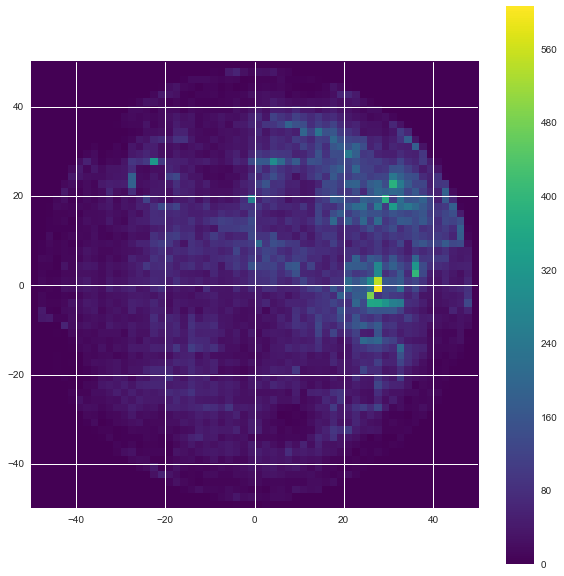

In [16]:
# Select only S2s with more than 10 hits and a valid interaction position
sel = (d_fancy['x_peak'] > -999999) & (d_fancy['type'] == 2) & (d_fancy['n_hits']>10)

plt.figure(figsize=(10,10))
plt.hist2d(d_fancy[sel]['x_peak'], d_fancy[sel]['y_peak'], range = ((-50,50),(-50,50)), bins=60)
ax = plt.gca()
ax.set_aspect(1)
plt.colorbar()
plt.show()